In [1]:
import os 
from glob import glob
from datetime import datetime

import numpy as np
import jax
import jax.numpy as jnp

import xarray as xr
import pandas as pd
import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature

from water_balance_jax import wbm_jax, construct_Kpet_vec
from initial_params import constants

In [2]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

In [3]:
#####################
#### Directories ####
#####################
project_data_path = "/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA"

In [4]:
# Parameter names
param_names = [
"awCap_scalar", "wiltingp_scalar", \
"alpha_claycoef", "alpha_sandcoef", "alpha_siltcoef", \
"betaHBV_claycoef", "betaHBV_sandcoef", "betaHBV_siltcoef", "betaHBV_elevcoef", \
"GS_start_corn", "GS_end_corn", "L_ini_corn", "L_dev_corn", "L_mid_corn", "Kc_ini_corn", "Kc_mid_corn", "Kc_end_corn", "K_min_corn", "K_max_corn", \
"GS_start_cotton", "GS_end_cotton", "L_ini_cotton", "L_dev_cotton", "L_mid_cotton", "Kc_ini_cotton", "Kc_mid_cotton", "Kc_end_cotton", "K_min_cotton", "K_max_cotton", \
"GS_start_rice", "GS_end_rice", "L_ini_rice", "L_dev_rice", "L_mid_rice", "Kc_ini_rice", "Kc_mid_rice", "Kc_end_rice", "K_min_rice", "K_max_rice", \
"GS_start_sorghum", "GS_end_sorghum", "L_ini_sorghum", "L_dev_sorghum", "L_mid_sorghum", "Kc_ini_sorghum", "Kc_mid_sorghum", "Kc_end_sorghum", "K_min_sorghum", "K_max_sorghum",\
"GS_start_soybeans", "GS_end_soybeans", "L_ini_soybeans", "L_dev_soybeans", "L_mid_soybeans", "Kc_ini_soybeans", "Kc_mid_soybeans", "Kc_end_soybeans", "K_min_soybeans", "K_max_soybeans", \
"GS_start_wheat", "GS_end_wheat", "L_ini_wheat", "L_dev_wheat", "L_mid_wheat", "Kc_ini_wheat", "Kc_mid_wheat", "Kc_end_wheat", "K_min_wheat", "K_max_wheat"
]

In [5]:
def read_inputs(subset_name, obs_name, remove_nans):
    ######################
    # Read obs
    obs = np.load(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.npy')

    ######################
    # Read and extract inputs
    npz = np.load(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/inputs.npz")

    # Meteo forcing
    tas = npz['tas']
    prcp = npz['prcp']

    # LAI
    lai = npz['lai']

    # Soil properties
    awCap = npz['awCap']
    wiltingp = npz['wiltingp']
    clayfrac = npz['clayfrac']
    sandfrac = npz['sandfrac']
    siltfrac = npz['siltfrac']

    # Land use
    corn = npz['corn']
    cotton = npz['cotton']
    rice = npz['rice']
    sorghum = npz['sorghum']
    soybeans = npz['soybeans']
    durum_wheat = npz['durum_wheat']
    spring_wheat = npz['spring_wheat']
    winter_wheat = npz['winter_wheat']
    wheat = durum_wheat + spring_wheat + winter_wheat
    
    cropland_other = npz['cropland_other']
    water = npz['water']
    evergreen_needleleaf = npz['evergreen_needleleaf']
    evergreen_broadleaf = npz['evergreen_broadleaf']
    deciduous_needleleaf = npz['deciduous_needleleaf']
    deciduous_broadleaf = npz['deciduous_broadleaf']
    mixed_forest = npz['mixed_forest']
    woodland = npz['woodland']
    wooded_grassland = npz['wooded_grassland']
    closed_shurbland = npz['closed_shurbland']
    open_shrubland = npz['open_shrubland']
    grassland = npz['grassland']
    barren = npz['barren']
    urban = npz['urban']
    
    all_other = cropland_other + water + evergreen_needleleaf + evergreen_broadleaf + deciduous_needleleaf + deciduous_broadleaf + mixed_forest + woodland + wooded_grassland + closed_shurbland + open_shrubland + grassland + barren + urban
    
    # Geophysical
    elev_std = npz['elev_std']
    
    lats = npz['lats']
    lons = npz['lons']
    
    # Initial conditions
    Ws_init = npz['soilMoist_init']

    ##########################
    # Prepare inputs for vmap:
    # spatial dimensions need to be collapsed and first
    # NaN gridpoints need to be removed
    nx = tas.shape[0]
    ny = tas.shape[1]
    nt = tas.shape[2]

    assert nt % 365 == 0
    nyrs = int(nt / 365)

    ## Obs
    ys = obs.reshape(nx * ny, nt)
    nan_inds_obs = jnp.isnan(ys).any(axis=1)

    ## Forcing: all days
    tas_in = tas.reshape(nx * ny, nt)
    prcp_in = prcp.reshape(nx * ny, nt)

    x_forcing_nt = jnp.stack([tas_in, prcp_in], axis=1)
    nan_inds_forcing_nt = jnp.isnan(x_forcing_nt).any(axis=(1,2))

    ## Forcing: yearly
    lai_in = lai.reshape(nx * ny, 365)
    x_forcing_nyrs = lai_in
    nan_inds_forcing_nyrs = jnp.isnan(x_forcing_nyrs).any(axis=1)

    ## Maps
    awCap_in = awCap.reshape(nx * ny)
    wiltingp_in = wiltingp.reshape(nx * ny)

    Ws_init_in = Ws_init.reshape(nx * ny)

    clayfrac_in = clayfrac.reshape(nx * ny)
    sandfrac_in = sandfrac.reshape(nx * ny)
    siltfrac_in = siltfrac.reshape(nx * ny)

    lats_in = np.tile(lats, nx)
    elev_std_in = elev_std.reshape(nx * ny)

    corn_in = corn.reshape(nx * ny)
    cotton_in = cotton.reshape(nx * ny)
    rice_in = rice.reshape(nx * ny)
    sorghum_in = sorghum.reshape(nx * ny)
    soybeans_in = soybeans.reshape(nx * ny)
    wheat_in = wheat.reshape(nx * ny)

    all_other_in = all_other.reshape(nx * ny)

    x_maps = jnp.stack([awCap_in, wiltingp_in, 
                        Ws_init_in, 
                        clayfrac_in, sandfrac_in, siltfrac_in, 
                        lats_in, elev_std_in,
                        corn_in, cotton_in, rice_in, sorghum_in, soybeans_in, wheat_in],
                       axis=1)
    nan_inds_maps = jnp.isnan(x_maps).any(axis=1)

    # Remove NaNs if desired
    if remove_nans:
        nan_inds = nan_inds_obs + nan_inds_forcing_nt + nan_inds_forcing_nyrs + nan_inds_maps
        ys = ys[~nan_inds]
        x_forcing_nt = x_forcing_nt[~nan_inds]
        x_forcing_nyrs = x_forcing_nyrs[~nan_inds]
        x_maps = x_maps[~nan_inds]

    # Return
    return ys, x_forcing_nt, x_forcing_nyrs, x_maps

In [6]:
def make_prediction(theta, constants, x_forcing_nt, x_forcing_nyrs, x_maps):
    # Read inputs
    tas, prcp = x_forcing_nt
    lai = x_forcing_nyrs
    
    awCap, wiltingp, \
    Ws_init, \
    clayfrac, sandfrac, siltfrac, \
    lats, elev_std, \
    corn, cotton, rice, sorghum, soybeans, wheat \
    = x_maps

    # Define all constants
    Ts, Tm, Wi_init, Sp_init = constants 
    
    # Define all params
    awCap_scalar, wiltingp_scalar, \
    alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
    betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
    GS_start_corn, GS_end_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
    GS_start_cotton, GS_end_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
    GS_start_rice, GS_end_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
    GS_start_sorghum, GS_end_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
    GS_start_soybeans, GS_end_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
    GS_start_wheat, GS_end_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat \
    = jnp.exp(theta)

    # Construct Kpet as weighted average
    Kpet_corn = construct_Kpet_vec(GS_start_corn, GS_end_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai)
    Kpet_cotton = construct_Kpet_vec(GS_start_cotton, GS_end_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, 1. - (L_ini_cotton + L_dev_cotton + L_mid_cotton), Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, lai)
    Kpet_rice = construct_Kpet_vec(GS_start_rice, GS_end_rice, L_ini_rice, L_dev_rice, L_mid_rice, 1. - (L_ini_rice + L_dev_rice + L_mid_rice), Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice, lai)
    Kpet_sorghum = construct_Kpet_vec(GS_start_sorghum, GS_end_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, 1. - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum), Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, lai)
    Kpet_soybeans = construct_Kpet_vec(GS_start_soybeans, GS_end_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, 1. - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans), Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, lai)
    Kpet_wheat = construct_Kpet_vec(GS_start_wheat, GS_end_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, 1. - (L_ini_wheat + L_dev_wheat + L_mid_wheat), Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat, lai)

    other = 1. - (corn + cotton + rice + sorghum + soybeans + wheat)
    weights = jnp.array([corn, cotton, rice, sorghum, soybeans, wheat, other])
    Kpets = jnp.array([Kpet_corn, Kpet_cotton, Kpet_rice, Kpet_sorghum, Kpet_soybeans, Kpet_wheat, jnp.ones(365)])
    Kpet = jnp.average(Kpets, weights = weights, axis=0)
    
    # params that WBM sees
    awCap_scaled = awCap * awCap_scalar
    wiltingp_scaled = wiltingp * wiltingp_scalar
    alpha = 1.0 + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    betaHBV = 1.0 + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac) + (betaHBV_elevcoef * elev_std)
    
    params = (Ts, Tm, wiltingp_scaled, awCap_scaled, alpha, betaHBV)
    
    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Kpet,
        Ws_init,
        Wi_init,
        Sp_init,
        lai,
        lats,
        params
    )

    return prediction

## Preliminaries

In [7]:
def get_jax_top(subset_name, obs_name, thresh):
    # Loop through files
    files = glob(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_res/*.txt')

    # Record count, corr, best RMSE, surprise index
    df_out = []
    for file in files:
        # Read
        df = pd.read_csv(file, sep = ' ')
        
        # Take all val_loss within 1%
        best_val_loss = df['train_loss'].min()
        if file.split("/")[-1].split("_")[0] == "kge":
            df_top = df[df['train_loss']/best_val_loss >= 1. - (thresh - 1.)]
        else:
            df_top = df[df['train_loss']/best_val_loss <= thresh]
        df_out.append(df_top)

    # Join and return
    df_out = pd.concat(df_out)
    return df_out

In [8]:
def simulate_jax(subset_name, obs_name, theta):
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, False)
    
    spatial_vmap = jax.jit(jax.vmap(make_prediction, in_axes=(None, None, 0, 0, 0), out_axes=0))

    out = spatial_vmap(
        theta,
        constants,
        x_forcing_nt,
        x_forcing_nyrs,
        x_maps
        )

    # Construct xr 
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    nt = out.shape[1]

    ds_sim = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(out.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

    return ds_sim

In [39]:
subset_name = 'centralUS'
obs_name = 'SMAP'

obs = np.load(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.npy")
# Construct xr 
lons = np.arange(-103.938, -80.5629999, 0.125)
lats = np.arange(36.063, 49.313001, 0.125)
nt = obs.shape[2]
ds_obs = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(obs.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

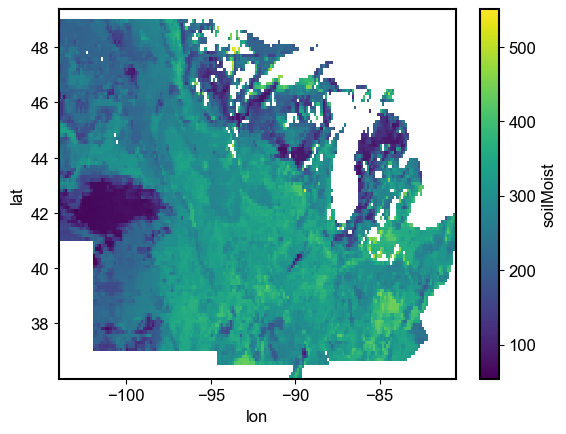

In [64]:
ds_obs.where(~ds_obs['soilMoist'].isnull().any(dim='time')).mean(dim='time', skipna=False).soilMoist.plot()

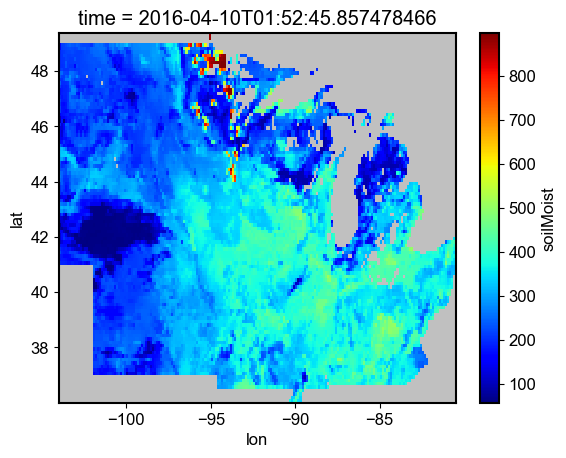

In [48]:
cmap = matplotlib.cm.jet
cmap.set_bad('silver',1.)
ds_obs.isel(time=100).soilMoist.plot(cmap=cmap)

In [71]:
# Plotting function
def plot_jax_map(subset_name, obs_name, thresh, plot_type, cbar, title, ax):
    """
    Plots the RMSE, coverage, or linear correlation map for a given obs-product.
    """
    # Get obs
    obs = np.load(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.npy")
    # Construct xr 
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    nt = obs.shape[2]
    ds_obs = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(obs.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))
    ds_obs = ds_obs['soilMoist']
    ds_obs = ds_obs.where(~ds_obs.isnull().any(dim='time'))
    
    # Get top params
    df_params = get_jax_top(subset_name, obs_name, thresh)
    
    if plot_type == 'coverage':
        # For coverage
        maxs = np.zeros(ds_obs.shape)
        mins = np.ones(ds_obs.shape) * 1000
    
        # Get ensemble bounds
        for index in range(len(df_params)):
            # Simulate
            ds_tmp = xr.open_dataset(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_out/{str(thresh)}thresh_{str(index)}.nc')['soilMoist']
            
            # Iterativalely calculate bounds
            maxs = np.max([maxs, ds_tmp.to_numpy()], axis=0)
            mins = np.min([mins, ds_tmp.to_numpy()], axis=0)
    
        # Get coverage
        coverage = 100 * (1 - ((((ds_obs.to_numpy() > maxs).sum(axis=0) + (ds_obs.to_numpy() < mins).sum(axis=0))) / ds_obs.shape[0]))

        # Construct ds for coverage
        ds_coverage = xr.Dataset(
            data_vars=dict(coverage=(["lat", "lon"], np.ma.masked_array(coverage, np.isnan(maxs[0,:,:])))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125),
                lat=np.arange(36.063, 49.313001, 0.125)))

        # Plot coverage
        cmap = matplotlib.cm.Greens
        cmap.set_bad('silver',1.)
        p = ds_coverage.coverage.plot(ax=ax, vmin=0, vmax=100, cmap = cmap, add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label=f"Coverage (%) from ensemble of {len(df_params)}",
                     ax=ax,
                     pad=0.04)
    elif plot_type == 'rmse':
        # Get best RMSE param
        theta_best_rmse = jnp.array([df_params.query("metric == 'rmse'").sort_values(by="train_loss").iloc[0][param] for param in param_names])
        ds_best = simulate_jax(subset_name, obs_name, theta_best_rmse)['soilMoist']
        # Plot best RMSE
        ds_rmse = np.sqrt(((ds_best - ds_obs)**2).mean(dim='time'))
        cmap = matplotlib.cm.Oranges
        cmap.set_bad('silver',1.)
        p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = cmap, transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Best RMSE [mm]",
                     ax=ax,
                     pad=0.04)
    elif plot_type == 'corr':
        # Get best RMSE param
        theta_best_rmse = jnp.array([df_params.query("metric == 'rmse'").sort_values(by="train_loss").iloc[0][param] for param in param_names])
        ds_best = simulate_jax(subset_name, obs_name, theta_best_rmse)['soilMoist']
        # Plot best correlation
        ds_corr = xr.corr(ds_best, ds_obs, dim='time')
        p = ds_corr.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, levels=21, cmap = "RdBu", transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Best correlation",
                     ax=ax,
                     pad=0.04)

    # Tidy
    ax.coastlines()
    ax.set_title(title)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

    return p

In [68]:
def plot_jax_ts_all(subset_name, obs_name, lat, lon, thresh, title, legend, ax):
    # For loookup
    def find_nearest(array, value):
        array = np.asarray(array)
        return (np.abs(array - value)).argmin()
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, False)
    
    # Get correct idx
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    idx_to_find = (find_nearest(lons, lon), find_nearest(lats, lat))
    shape_to_search = (x_maps.shape[0],)
    original_shape = (len(lons), len(lats))
    idx = np.unravel_index(np.ravel_multi_index(idx_to_find, original_shape), shape_to_search)[0]

    # Plot obs
    obs = ys[idx,:]
    dates = pd.date_range(start='01/01/2016', end='12/31/2022', periods=len(obs))
    ax.plot(dates, obs, color='darkred', zorder=3, lw=2, label=obs_name)
    
    # Get top
    df_top = get_jax_top(subset_name, obs_name, thresh)

    # Record count, corr, best RMSE, surprise index
    sim_all = []
    for index, row in df_top.iterrows():
        # Get params
        theta = jnp.array([row[param] for param in param_names])
            
        # Simulate
        sim = make_prediction(theta, constants, x_forcing_nt[idx,:,:], x_forcing_nyrs[idx,:], x_maps[idx,:])

        # Plot
        ax.plot(dates, sim, color='silver', alpha=0.8, zorder=2)
        
        # Append for surpise index
        sim_all.append(sim)

    # Add info
    best_theta = jnp.array([df_top.sort_values(by='train_loss').iloc[0][param] for param in param_names])
    best_sim = make_prediction(best_theta, constants, x_forcing_nt[idx,:,:], x_forcing_nyrs[idx,:], x_maps[idx,:])
    ax.plot(dates, best_sim, color='silver', lw=3, zorder=2, alpha=0.8, label='Uncertainty bounds')
    ax.plot(dates, best_sim, color='gray', lw=2, zorder=2, label='Best parameter set')
    
    best_rmse = np.sqrt(np.mean((best_sim - obs)**2))
    best_corr = np.corrcoef(best_sim, obs)[0,1]
    maxs = np.max(sim_all, axis=0)
    mins = np.min(sim_all, axis=0)
    coverage = 1 - ((((obs > maxs).sum() + (obs < mins).sum())) / len(obs))

    text = f"RMSE: {best_rmse:.2f}mm, Corr.: {best_corr:.2f}, Coverage: {100*coverage:.2f}%"
    ax.text(x=0.03, y=0.96,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=11)
    
    ax.text(x=0.77, y=0.96,
            s=f"Ensemble size: {str(len(df_top))}",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=11)
    
    ax.grid()
    if legend:
        ax.legend(ncols = 3, loc='lower right', columnspacing=1.)
    ax.set_title(title)
    ax.set_ylim([ax.get_ylim()[0],1.05*ax.get_ylim()[1]])
    ax.set_ylabel("Soil Moisture [mm]")
    ax.set_xlabel('')

### Simulate top results

In [11]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="10GiB",
    walltime="00:30:00"
)
cluster.scale(jobs=30)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.162:45459,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [26]:
def simulate_store_jax(subset_name, obs_name, theta, thresh, i):
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, False)
    
    spatial_vmap = jax.jit(jax.vmap(make_prediction, in_axes=(None, None, 0, 0, 0), out_axes=0))

    out = spatial_vmap(
        theta,
        constants,
        x_forcing_nt,
        x_forcing_nyrs,
        x_maps
        )

    # Construct xr 
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    nt = out.shape[1]

    ds_sim = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(out.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

    ds_sim.to_netcdf(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_out/{str(thresh)}thresh_{str(i)}.nc')

In [29]:
# Simulate all outputs to make reading easier
thresh = 1.01
subset_name = 'centralUS'

delayed = []

for obs_name in ['SMAP']:
# for obs_name in ['SMAP', 'VIC', 'MOSAIC', 'NOAH']:
    df_params = get_jax_top(subset_name, obs_name, thresh)
    for index, row in df_params.reset_index().iterrows():
        theta = jnp.array([row[param] for param in param_names])
        delayed.append(dask.delayed(simulate_store_jax)(subset_name, obs_name, theta, thresh, index))

# Compute
_ = dask.compute(*delayed)

## Plots

### Map plots

CPU times: user 3min 17s, sys: 3min 36s, total: 6min 54s
Wall time: 8min 39s


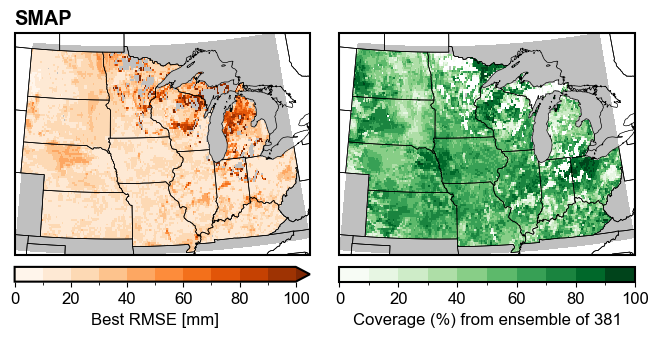

In [72]:
%%time
# Main plot: maps
subset_name = 'centralUS'
obs_name = 'SMAP'
thresh = 1.01

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='rmse', cbar=True, title='', ax=axs[0])
plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='coverage', cbar=True, title='', ax=axs[1])

axs[0].set_title(obs_name, loc='left', fontdict={'fontweight': 'bold'})

plt.savefig(f'../figs/JAX_{obs_name}_map.png', dpi=600)

CPU times: user 4min 14s, sys: 4min 50s, total: 9min 4s
Wall time: 12min 36s


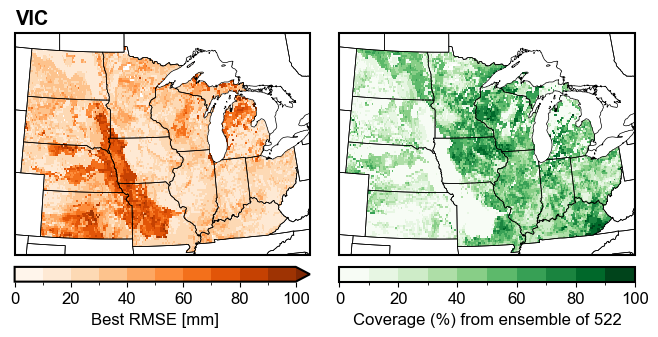

In [20]:
%%time
# Main plot: maps
subset_name = 'centralUS'
obs_name = 'VIC'
thresh = 1.01

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='rmse', cbar=True, title='', ax=axs[0])
plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='coverage', cbar=True, title='', ax=axs[1])

axs[0].set_title(obs_name, loc='left', fontdict={'fontweight': 'bold'})

plt.savefig(f'../figs/JAX_{obs_name}_map.png', dpi=600)

CPU times: user 3min 38s, sys: 4min 8s, total: 7min 47s
Wall time: 10min 36s


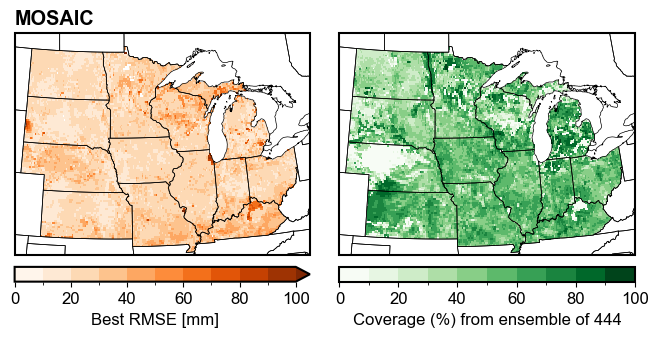

In [21]:
%%time
# Main plot: maps
subset_name = 'centralUS'
obs_name = 'MOSAIC'
thresh = 1.01

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='rmse', cbar=True, title='', ax=axs[0])
plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='coverage', cbar=True, title='', ax=axs[1])

axs[0].set_title(obs_name, loc='left', fontdict={'fontweight': 'bold'})

plt.savefig(f'../figs/JAX_{obs_name}_map.png', dpi=600)

CPU times: user 4min, sys: 4min 36s, total: 8min 37s
Wall time: 12min 35s


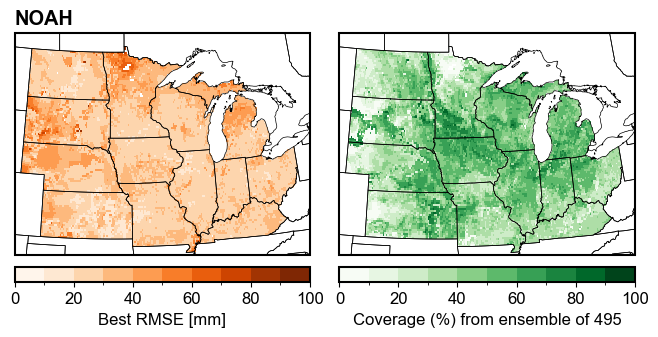

In [22]:
%%time
# Main plot: maps
subset_name = 'centralUS'
obs_name = 'NOAH'
thresh = 1.01

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='rmse', cbar=True, title='', ax=axs[0])
plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='coverage', cbar=True, title='', ax=axs[1])

axs[0].set_title(obs_name, loc='left', fontdict={'fontweight': 'bold'})

plt.savefig(f'../figs/JAX_{obs_name}_map.png', dpi=600)

### Timeseries plots

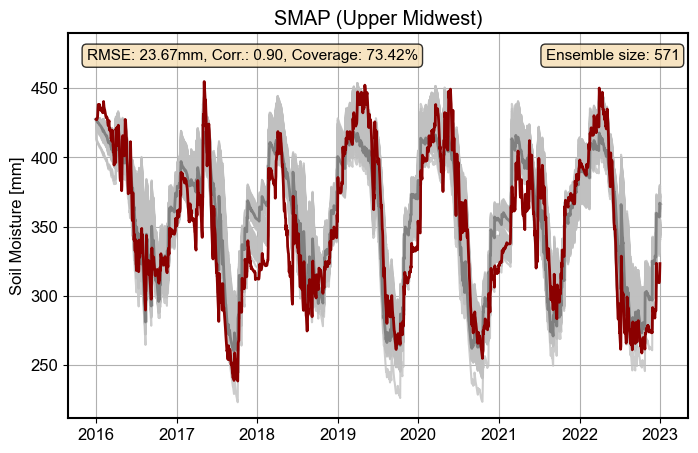

In [33]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'SMAP'

lat, lon = 39.96077694862997, -88.44932637651797 # Illinois

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Central Midwest)",
                ax=ax)

plt.show()

In [34]:
lat, lon = 39.96077694862997, -88.44932637651797

print(f"awCap: {smap_awCap.sel(lat=lat, lon=lon, method='nearest').awCap.values * 0.9}")
print(f"wiltingp: {smap_wiltingp.sel(lat=lat, lon=lon, method='nearest').wiltingp.values * 1.2}")

awCap: 275.6699890136719
wiltingp: 231.48001098632812


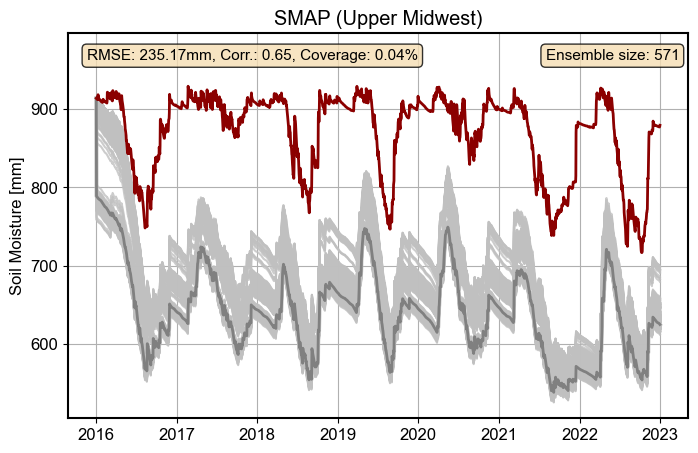

In [12]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'SMAP'

lat, lon = 45.660126978388895, -87.641380949398 # upper Midwest

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Upper Midwest)",
                ax=ax)

plt.show()

In [22]:
smap_awCap = xr.open_dataset("/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/geo_inputs/SMAP_awCap.nc")
smap_wiltingp = xr.open_dataset("/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/geo_inputs/SMAP_wiltingp.nc")

In [35]:
lat, lon = 45.660126978388895, -87.641380949398

print(f"awCap: {smap_awCap.sel(lat=lat, lon=lon, method='nearest').awCap.values}")
print(f"wiltingp: {smap_wiltingp.sel(lat=lat, lon=lon, method='nearest').wiltingp.values}")

awCap: 588.5
wiltingp: 341.5


In [36]:
lat, lon = 45.660126978388895, -87.641380949398

print(f"awCap: {smap_awCap.sel(lat=lat, lon=lon, method='nearest').awCap.values * 0.85}")
print(f"wiltingp: {smap_wiltingp.sel(lat=lat, lon=lon, method='nearest').wiltingp.values * 1.2}")

awCap: 500.22499999999997
wiltingp: 409.8


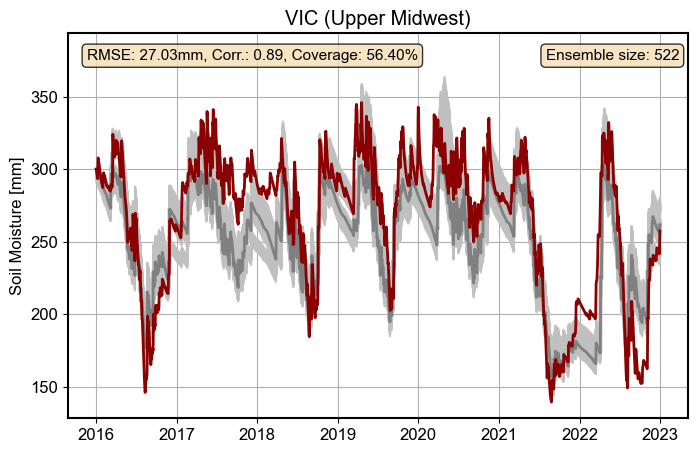

In [31]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 45.660126978388895, -87.641380949398 # upper Midwest

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Upper Midwest)",
                ax=ax)

plt.show()

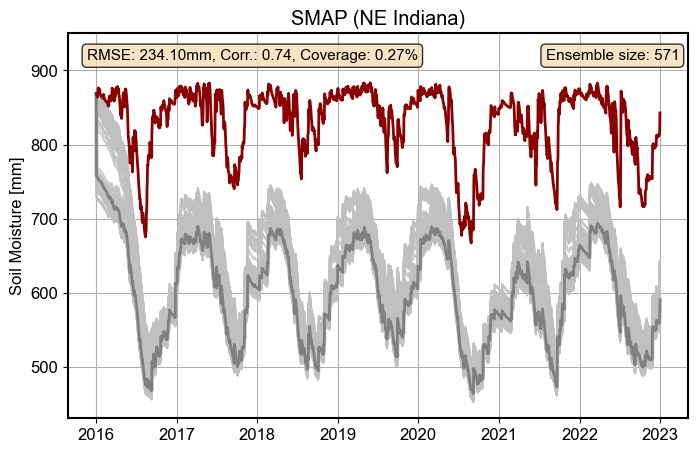

In [38]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'SMAP'

lat, lon = 41.21712676021884, -85.0522563937162 # NE Indiana

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (NE Indiana)",
                ax=ax)

plt.show()

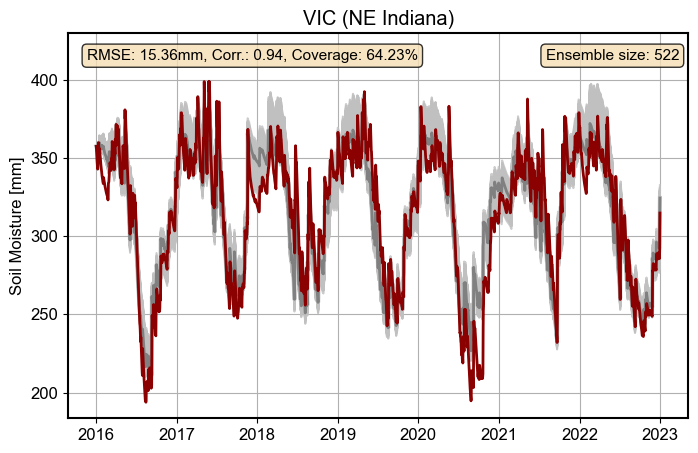

In [32]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 41.21712676021884, -85.0522563937162 # NE Indiana

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (NE Indiana)",
                ax=ax)

plt.show()

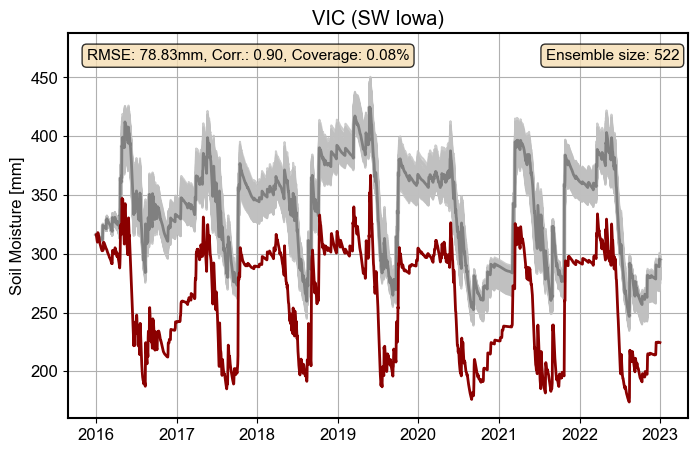

In [39]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 40.76063537671462, -95.39930528494172 # SW Iowa

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (SW Iowa)",
                ax=ax)

plt.show()

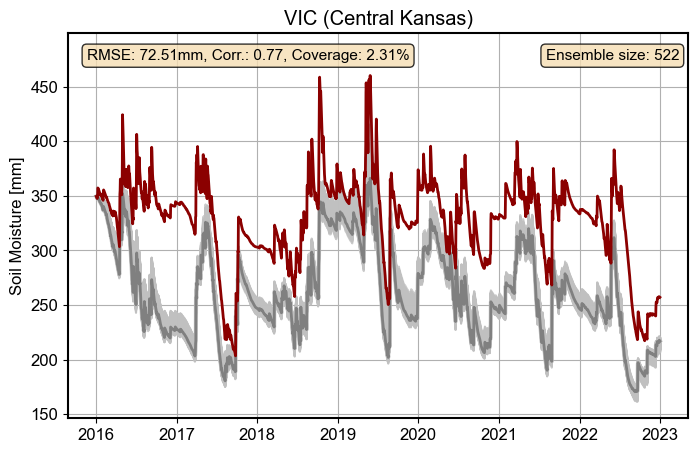

In [40]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 38.504984973848856, -98.3657123416093 # central KS

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Central Kansas)",
                ax=ax)

plt.show()

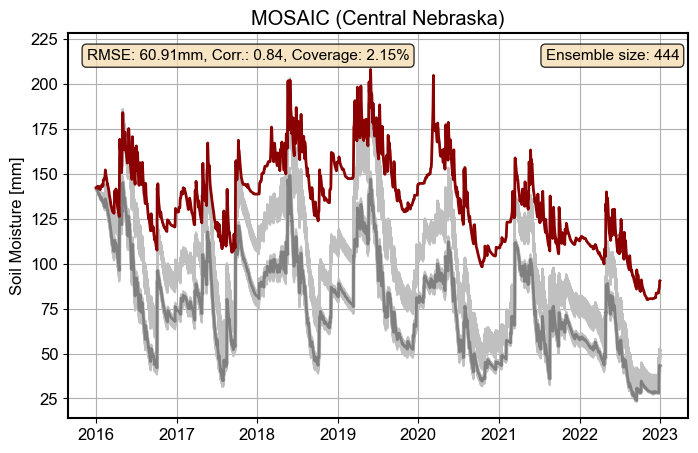

In [42]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'MOSAIC'

lat, lon = 41.86969145376092, -100.97115781699968 # central NE

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Central Nebraska)",
                ax=ax)

plt.show()

### Parameters

In [74]:
def plot_params(subset_name, obs_name, thresh, params, axs):
    # Read top params
    df_params = get_jax_top(subset_name, obs_name, thresh)

    # Metrics
    # metrics = ['rmse', 'mse', 'kge', 'q0-25rmse', 'q75-100rmse']
    metrics = ['rmse', 'kge', 'q0-25rmse', 'q75-100rmse']
    # Plot
    for ix, param in enumerate(params):
        ax=axs[ix]
        ax.set_title(param)
        for metric in metrics:
            np.exp(df_params[df_params['metric'] == metric][param]).plot.kde(label=metric, ax=ax, lw=2)
        if ax.get_xlim()[0] < 0:
            ax.set_xlim([0, ax.get_xlim()[1]])
        ax.grid()
        ax.set_yticklabels([])
        ax.set_ylabel('')

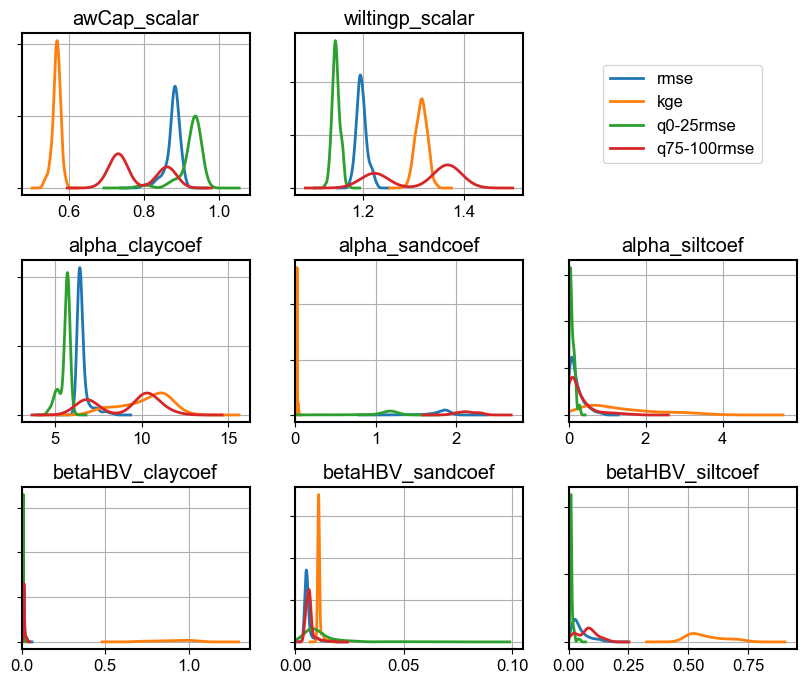

In [75]:
subset_name = 'centralUS'
obs_name = 'SMAP'
thresh = 1.01

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

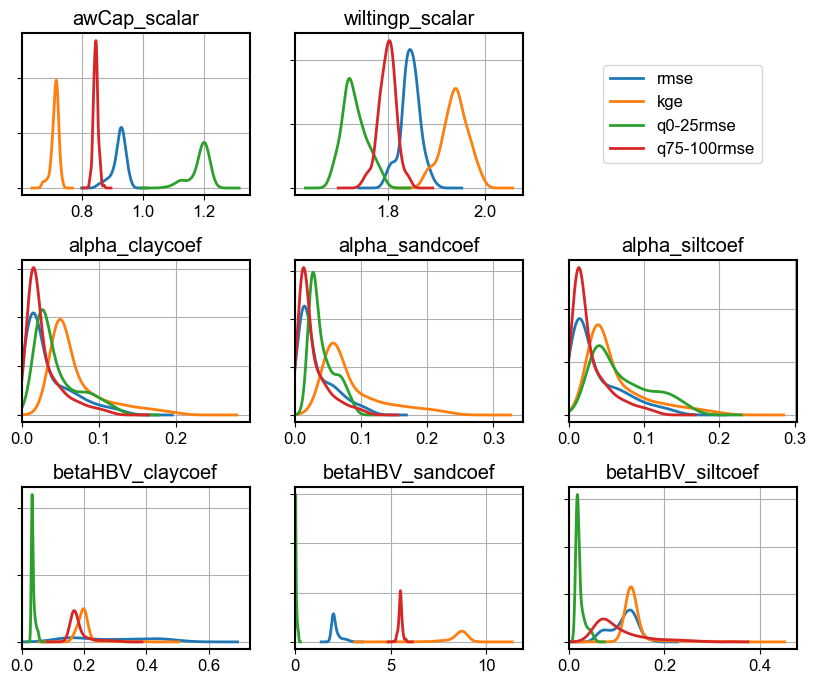

In [76]:
subset_name = 'centralUS'
obs_name = 'VIC'
thresh = 1.01

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

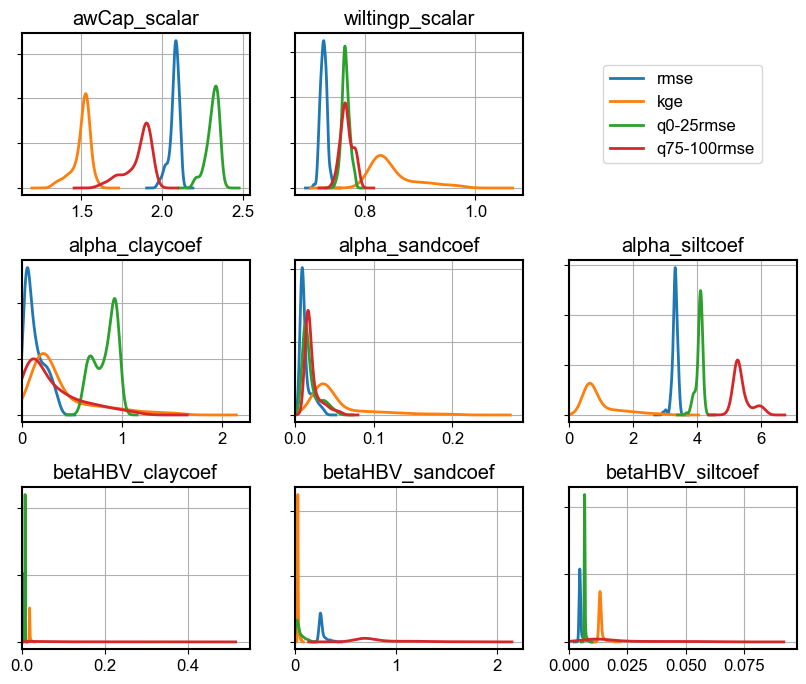

In [69]:
subset_name = 'centralUS'
obs_name = 'MOSAIC'
thresh = 1.01

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

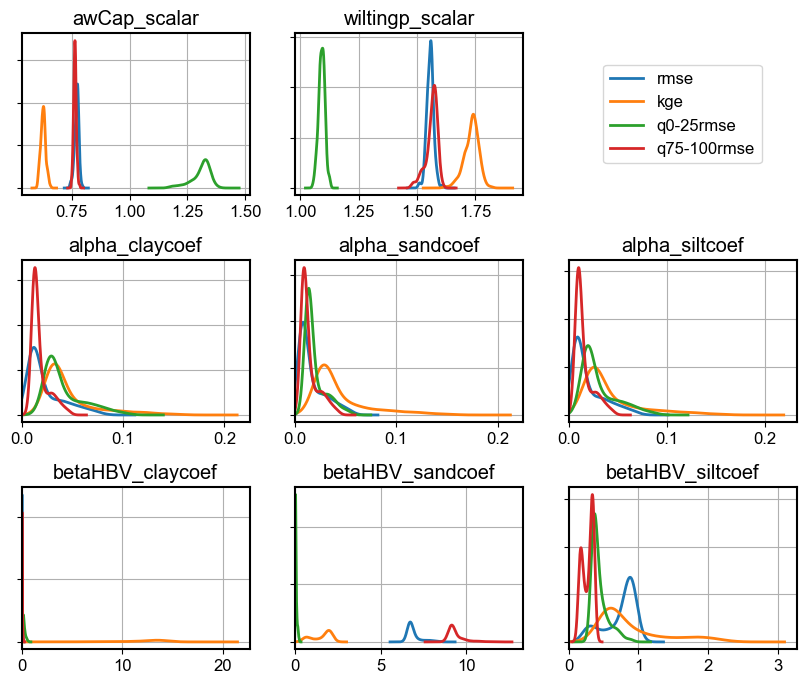

In [70]:
subset_name = 'centralUS'
obs_name = 'NOAH'
thresh = 1.01

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

### Old Plots

In [ ]:
# Read sim
def plot_precal_map(obs, title, ax):
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs.upper()}/{obs.upper()}_validation.nc')
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs.upper()}/soilMoist_rmse_skip0.csv')
    iparam_best = df_res.sort_values(by='rmse_gpa')['iparam'].to_numpy()[0]
    
    # Read simulation output
    sim_tmp = np.load(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs.upper()}/out/{str(iparam_best)}.npy')
    # sim_tmp = np.load(f'{project_data_path}/WBM/calibration/centralUS_old/out/{str(iparam)}.npy')

    # Construct xr 
    ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125), # CENTRAL US ONLY!
                lat=np.arange(36.063, 49.313001, 0.125), # CENTRAL US ONLY!
                time=pd.date_range(start='01/01/2016', end='12/31/2022')))
    
    # Plot
    ds_rmse = np.sqrt(((ds_sim['soilMoist'] - ds_obs['soilMoist'])**2).mean(dim='time'))
    p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.set_title(title)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

    return p, ds_rmse

In [ ]:
# Read sim
def plot_best_ts(obs_name, n_cutoff, lat, lon, title, ax):
    # For loookup
    def find_nearest(array, value):
        array = np.asarray(array)
        return (np.abs(array - value)).argmin()
        
    # Get correct idx
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    idy = find_nearest(lats, lat)
    idx = find_nearest(lons, lon)

    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/{obs_name.upper()}_validation.nc')
    obs = ds_obs.sel(lat=lat, lon=lon, method='nearest')['soilMoist'].to_numpy()

    # Get dates
    dates = pd.date_range(start='01/01/2016', end='12/31/2022', periods=len(obs))
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/soilMoist_rmse_skip0.csv')
    iparam_top_n = df_res.sort_values(by='rmse_gpa')['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    sim_best = np.load(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/out/{str(iparam_best)}.npy')

    # For surprise_index
    sim_all = []
    
    # Plot simulations
    for iparam in iparam_top_n:
        # Read
        sim_tmp = np.load(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/out/{str(iparam)}.npy')

        # Plot
        ax.plot(dates, sim_tmp[idx, idy, :], color='silver', alpha=0.8)
        
        # Append for surpise index
        sim_all.append(sim_tmp[idx, idy, :])
    
    # Plot
    ax.plot(dates, obs, color='darkred', zorder=3, label='Obs.')
    ax.plot(dates, sim_best[idx, idy, :], color='gray', zorder=2, label='Best (global)')

    # Info
    best_rmse = np.sqrt(((sim_best[idx, idy, :] - obs)**2).mean())
    best_corr = np.corrcoef(sim_best[idx, idy, :], obs)[0,1]
    
    maxs = np.max(sim_all, axis=0)
    mins = np.min(sim_all, axis=0)
    coverage = 1 - ((((obs > maxs).sum() + (obs < mins).sum())) / len(obs))

    text = f"RMSE: {best_rmse:.2f}mm, Corr.: {best_corr:.2f}, Coverage: {100*coverage:.2f}%"
    ax.text(x=0.03, y=0.96,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)

    ax.grid()
    ax.legend(loc='lower right')
    ax.set_title(title)
    ax.set_ylabel("Soil Moisture")
    ax.set_xlabel('')

In [ ]:
def plot_precal_kde(obs_name, color, n_cutoff, param, label, ax):
    df_params = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/params_extra.csv')
    
    # Get top params
    df_res = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/soilMoist_rmse_skip0.csv')
        
    iparam_top_n = df_res.sort_values(by='rmse_gpa')['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    df_params.iloc[iparam_top_n][param].plot.kde(ax=ax, color=color, label=label, lw=2)

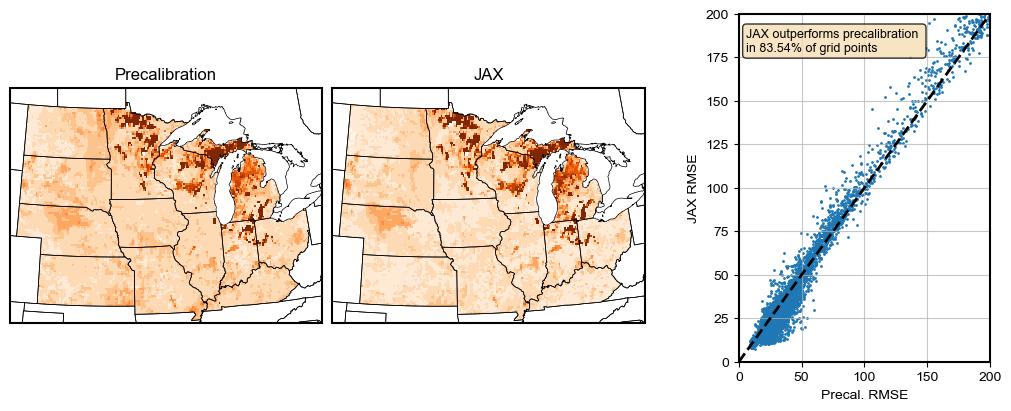

In [183]:
fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[2,1])

axsLeft = subfigs[0].subplots(1, 2, subplot_kw=dict(projection=ccrs.LambertConformal()))

obs = 'SMAP'
p, precal_rmse = plot_precal_map(obs, 'Precalibration', axsLeft[0])
p, jax_rmse = plot_jax_map(obs, 'JAX', axsLeft[1])

fig.colorbar(p,
             orientation="horizontal",
             label=f"RMSE [mm]",
             ax=axs[:2],
             shrink=0.5,
             pad=0.04)

# scatter
axsRight = subfigs[1].subplots(1, 1)
ax=axsRight
ax.scatter(x = precal_rmse.to_numpy().flatten(),
            y = jax_rmse.to_numpy().flatten(),
            s=1)

maxlim = np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
ax.plot([0, maxlim], [0, maxlim], lw=2, ls='--', color='black')
ax.set_xlim([0,200])
ax.set_ylim([0,200])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.grid(alpha=0.7)
ax.set_xlabel('Precal. RMSE')
ax.set_ylabel('JAX RMSE')

diffs = precal_rmse.to_numpy().flatten() - jax_rmse.to_numpy().flatten()
diffs = diffs[~np.isnan(diffs)]
ax.text(x=0.03, y=0.96,
        s = f"JAX outperforms precalibration \nin {100*np.mean(diffs > 0.):.2f}% of grid points",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)

# plt.savefig('../figs/JAX_presentation/map_scatter_best.png', dpi=600)
plt.show()

In [16]:
# Read JAX
df_out = get_jax_top('SMAP', 1.1)

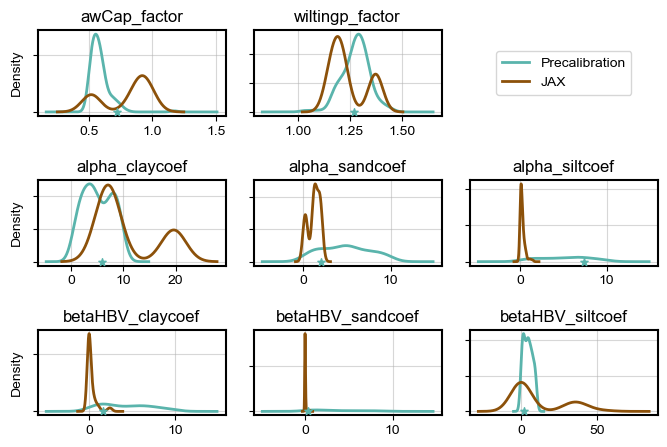

In [54]:
# Do the parameters match?
n_cutoff = 150
metric = 'rmse_gpa'
tmin = 0

#######################
# PRECAL
#######################
# Read params
df_params = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/params_extra.csv')

params = ['awCap_factor',
          'wiltingp_factor',
          'alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef',
          'betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef']
priors = ['U(0.1, 5)',
          'U(0.1, 5)',
          'U(0, 10)', 'U(0, 10)', 'U(0, 10)',
          'U(0, 10)', 'U(0, 10)', 'U(0, 10)']
xlims = [[0.1, 3],
          [0.1, 3],
          [0, 10], [0, 10], [0, 10],
          [0, 10], [0, 10], [0, 10]]
# obs_all = ['noah', 'mosaic']
# obs_colors = ['C0', 'C0', 'C0', 'C0']

obs_all = ['smap', 'vic', 'noah', 'mosaic']
obs_colors = ['#5ab4ac', '#8c510a', '#bf812d', '#d8b365']

obs_all = [obs]
obs_colors = ['#5ab4ac']

fig, axs = plt.subplots(3,3, figsize=(8,5), gridspec_kw={'hspace':0.75, 'wspace':0.15})
axs=axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get top params
    df_res = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs.upper()}/soilMoist_rmse_skip{str(tmin)}.csv')
        
    iparam_top_n = df_res.sort_values(by=metric)['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    for idx, param in enumerate(params):
        if idx >= 2:
            idxx = idx + 1
        else:
            idxx = idx
        # Plot
        df_params.iloc[iparam_top_n][param].plot.kde(ax=axs[idxx], color=obs_colors[ido], label='Precalibration', lw=2)
        # Best
        axs[idxx].scatter(x = [df_params.iloc[iparam_best][param]],
                         y = [0],
                         marker = '*', color=obs_colors[ido], zorder=100, s=30)

###########################
# JAX
#########################
jax_colors = ['#8c510a', '#bf812d']

# Read JAX
df_out = get_jax_best('SMAP', 1.01)

for idx, param in enumerate(params):
    if idx >= 2:
        idxx = idx + 1
    else:
        idxx = idx
    # Best
    np.exp(df_out[param.replace('_factor', '_scalar')]).plot.kde(ax=axs[idxx], color=jax_colors[0], lw=2, label='JAX')
    

# for ido, param_read_str in enumerate(['_rmse_', '_mse_']):
#     file = glob(f'{project_data_path}/WBM/calibration/centralUS/{obs}/training_res/*{param_read_str}*')[0]
#     theta = pd.read_csv(file, sep=';', names = ['info', 'theta']).iloc[-1]['theta'].replace(' theta: ', '').split(',')
#     theta = np.exp([float(x) for x in theta])
#     # Loop through params
#     for idx, param in enumerate(params):
#         if idx >= 2:
#             idxx = idx + 1
#         else:
#             idxx = idx
#         # Best
#         axs[idxx].scatter(x = [theta[idx]],
#                          y = [0],
#                          marker = '^', color=jax_colors[ido], zorder=100, s=30)

# Tidy
for idx, param in enumerate(params):
    if idx >= 2:
        idxx = idx + 1
    else:
        idxx = idx
    axs[idxx].set_title(f'{param}')
    # axs[idxx].set_xlim(xlims[idx])
    axs[idxx].set_yticklabels([])
    axs[idxx].grid(alpha=0.5)
    if idxx not in [0,3,6]:
        axs[idxx].set_ylabel('')
    
# Legend in odd plot
axs[2].axis("off")
axs[2].set_xlim(axs[2].get_xlim())
axs[2].set_ylim(axs[2].get_ylim())
legend_elements = [Line2D([10], [10], color=obs_colors[0], lw=2, label='Precalibration'),
                   Line2D([10], [10], color=jax_colors[0], lw=2, label='JAX')]
                    # Line2D([10], [10], color=obs_colors[3], lw=2, label=obs_all[3].upper()),
                    # Line2D([10], [10], marker='^', markerfacecolor=obs_colors[0], color='w', markersize=9, label='SMAP Best'),
                    # Line2D([10], [10], marker='^', markerfacecolor=jax_colors[0], color='w', markersize=9, label='JAX RMSE'),
                    # Line2D([10], [10], marker='^', markerfacecolor=jax_colors[1], color='w', markersize=9, label='JAX MSE')]

axs[2].legend(handles=legend_elements, loc='center')

plt.show()

In [9]:
# ixy = 14503

# plt.plot(make_prediction(initial_params, constants, x_forcing_nt[ixy, :, :], x_forcing_nyrs[ixy, :], x_maps[ixy, :]))
# plt.plot(ys[ixy,:])
# loss_fn(initial_params,constants,x_forcing_nt[ixy,:,:], x_forcing_nyrs[ixy,:] ,x_maps[ixy,:], ys[ixy,:])